<a href="https://colab.research.google.com/github/aryy-hue/Bottle-Identification-and-Liquid-Level-Analysis-System/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving blud.jpg to blud.jpg
Detection bottle: Blood Transfusion Bottle
Fluid level: Half - 68.23%


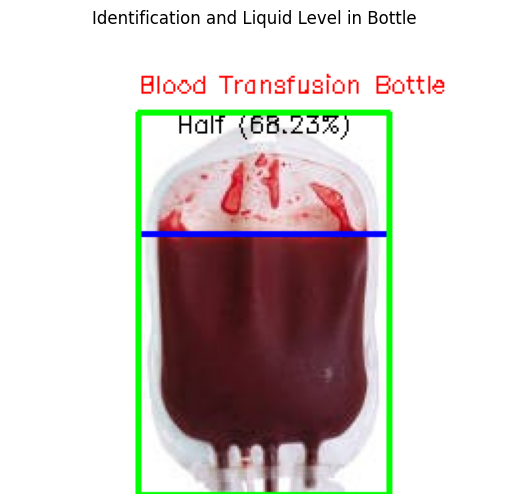

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Function to display the image
def show_image(title, img):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Upload image file
uploaded = files.upload()

# Choose the uploaded file
image_path = next(iter(uploaded))

# Read the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Remove small noise using morphological operations
kernel = np.ones((3, 3), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours from the thresholded image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour as the bottle and identify its type
if contours:
    # Sort contours by area to find the largest bottle
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)

        # Identify bottle type based on aspect ratio (width/height)
        aspect_ratio = float(w) / h
        if 0.2 < aspect_ratio < 0.5:
            botol_type = "Medicine Bottle"
        elif aspect_ratio < 0.8:
            botol_type = "Blood Transfusion Bottle"
        else:
            botol_type = "Other Medicine Bottles"

        # Calculate the center position of the bounding box
        center_x = x + w // 2
        center_y = y + h // 2

        # Display the bottle type at the top edge of the image with small text
        top_text_y = y - 10
        cv2.putText(image, botol_type, (x, top_text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        print(f"Detection bottle: {botol_type}")

        # Determine bottle height to calculate fluid level
        bottle_height = h

        # Segment the region to detect the liquid area
        liquid_region = gray[y:y+h, x:x+w]
        liquid_height = 0
        for i in range(liquid_region.shape[0]):
            row_mean = np.mean(liquid_region[i, :])
            if row_mean < 150:
                liquid_height = h - i
                break

        # Calculate the percentage of the liquid volume
        liquid_percentage = (liquid_height / bottle_height) * 100
        level = "Full" if liquid_percentage > 80 else "Half" if liquid_percentage > 30 else "Empty"

        # Display the fluid level information at the center with small text
        cv2.line(image, (x, y + h - liquid_height), (x + w, y + h - liquid_height), (255, 0, 0), 2)

        # Display the fluid level information at the top with small text
        level_text = f"{level} ({liquid_percentage:.2f}%)"
        level_text_size = cv2.getTextSize(level_text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]  # Small font size
        level_text_x = center_x - (level_text_size[0] // 2)
        level_text_y = top_text_y + 20

        cv2.putText(image, level_text, (level_text_x, level_text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)  # Small font size
        print(f"Fluid level: {level} - {liquid_percentage:.2f}%")

        # Draw a bounding box around the contour
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green color for contour detection

        break  # Use the largest contour as the main bottle

    # Display the result
    show_image("Identification and Liquid Level in Bottle", image)
else:
    print("No bottles detected.")
